# 캐글신용카드 사기검출
## Boosting, SMOTE 오버 샘플링 적용

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 (99 : 0.01_이상레이블을 가진 건수가 정상레이블을 가진 건수에 비해 너무 작을 때) 정상 레이블로 치우친 학습을 수행하게 됨 -> 이상 데이터 검출이 어려움

불균형한 레이블 값 분포를 적절한 학습 데이터로 보완하는 방법
1. 오버 샘플링 : 적은 레이블을 가진 데이터 세트를 많은 레이블을 가진 데이터 만큼 증식
  - 예측 성능상 조금 유리한 경우가 많아 상대적으로 많이 사용됨
  - 과적합을 방지하기 위해 원본 데이터 피처 값을 약간씩 변경 필요 (대표적인 방법: SMOTE)
  - SMOTE : 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 해당 데이터와 K개 이웃들의 차이를 일정 값으로 만들어 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식
  

2. 언더 샘플링 
  - 많은 데이터 세트를 적은 데이터 만큼 감소
  - 정상 레이블의 경우 제대로 된 학습을 수행할 수 없는 문제 발생

## 1. 데이터 확인 및 일차 가공 및 모델학습/ 예측/평가

### 1) 데이터 불러오기

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv('creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2) 필요 값 반환하는 함수 생성(가공데이터반환, 학습용/test용 반환)

In [6]:
from sklearn.model_selection import train_test_split

# 필요컬럼만 추출하는 함수 생성
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True) # Time컬럼은 필요 없어서 삭제
    return df_copy

# 학습과 test 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    
    # 데이터의 맨 마지막 칼럼이 레이블, 나머지는 피처
    X_fea = df_copy.iloc[:, :-1]
    y_la = df_copy.iloc[:, -1]
    
    # 데이터 학습, 테스트 용 분할
    X_train, X_test, y_train, y_test = train_test_split(X_fea, y_la, test_size = 0.3, random_state=0, stratify=y_la) # Stratified 기반 분할
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

### 3) 값 확인

In [16]:
# 값 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/len(y_train))
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/len(y_test))

학습 데이터 레이블 값 비율
0    0.998275
1    0.001725
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    0.998268
1    0.001732
Name: Class, dtype: float64


-> 학습데이터, 테스트데이터 레이블 값 비율이 거의 비슷하게 분할됨

### 4) 모델 학습 및 예측/평가 

In [11]:
# 오차행렬, 정확도, 정밀도, 재현율, f1, AUC 평가 함수
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

- 로지스틱 모델 학습

In [12]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_predproba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_predproba)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9584


In [19]:
# 위 방법을 좀 더 간단하게 모델도 인자로 집어넣어 구하는 함수 생성
def get_model_train_eval(model, ftr_train = None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

- LGBM 모델 학습

In [20]:
# LGBM 모델 생성
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs=-1, boost_from_average=False) # n_jobs 코어수에대한 옵션(-1은 전부 사용한다는 의미)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


=> 로지스틱보다 좀 더 개선된 값으로 나옴(정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9584)

#### 과제09_22_1. 상기 과제에 대하여 다음을 수행하세요.
- 데이터 분포도 변환 후 모델 학습/예측/평가
- 이상치 데이터 제거 후 모델 학습/예측/평가
- SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

## 2. 데이터 분포도 변환 후 모델 학습/예측/평가

In [23]:
# 중요 피처값의 분포도 확인(왜곡된 분포도를 가지는 데이터를 재가공하기 위해)
card_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


=> 대부분의 컬럼 값의 범위가 비슷 but Amount 컬럼이 표준변차 값 250으로 큼 (확인해보기)

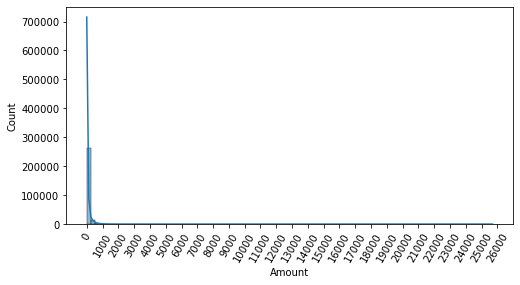

In [27]:
import seaborn as sns

plt.figure(figsize = (8, 4))
plt.xticks(range(0, 28000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [30]:
card_df['Amount'].value_counts()

1.00       13688
1.98        6044
0.89        4872
9.99        4747
15.00       3280
           ...  
62.09          1
552.05         1
1467.75        1
196.68         1
95.63          1
Name: Amount, Length: 32767, dtype: int64

=> 카드 사용금액이 1000불 이하인 데이터가 대부분, 전체 중 약 60%가 2불 미만/
(정규분포 형태로 변환하기)

### 1) StandardScaler 사용하여 정규분포 형태로 변환

In [33]:
# Amount 컬럼 정규분포 형태로 변환
from sklearn.preprocessing import StandardScaler# 정규분포 형태로 변환해줌

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    #변환된 amount데이터를 DF 맨 앞에 입력
    df_copy.insert(0, 'Amount_scaled', amount_n) #위치, 컬럼명, 대입 값 입력
    df_copy.drop(['Time', 'Amount'], axis=1, inplace = True) # 필요없는 컬럼과 정규화하기전 컬럼 제거
    return df_copy # 정규화된 컬럼이 있는 df 반환

- 분포도 확인

In [43]:
check_df = get_preprocessed_df(card_df)
check_df['Amount_scaled'].value_counts()

0.693147    13688
1.091923     6044
0.636577     4872
2.396986     4747
2.772589     3280
            ...  
4.144562        1
6.315448        1
7.292167        1
5.286650        1
4.570889        1
Name: Amount_scaled, Length: 32767, dtype: int64

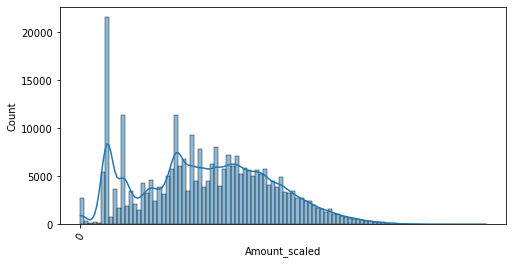

In [44]:
plt.figure(figsize = (8, 4))
plt.xticks(range(0, 28000, 1000), rotation=60)
sns.histplot(check_df['Amount_scaled'], bins=100, kde=True)
plt.show()

- 학습용, 테스트용 데이터를 생성 후 로지스틱과 LGBM모델로 학습/예측/평가

In [35]:
# Amout를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LGBM 수행

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('---------로지스틱 회귀 예측 성능---------')
lr_clf = LogisticRegression(max_iter=1000) #Gradient Descent 방식을 반복해서 몇번 수행할 것인지 지정
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) # 모델학습 인자로 집어넣어 평가 값 구하는 함수사용

print('---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

print('---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

---------로지스틱 회귀 예측 성능---------
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------
오차 행렬
[[85256    39]
 [  121    27]]
정확도: 0.9981, 정밀도: 0.4091, 재현율: 0.1824,    F1: 0.2523, AUC:0.5943
---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


- 데이터 변환 하기 전(로지스틱-정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9584) 이랑 비교했을 때 큰 차이가 없음
- LGBM의 변화 전 값(정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790)
- 로지스틱: 정밀도와 재현율 둘다 저하, LGBM: 정밀도와 재현율이 약간 저하

### 2) log1p를 사용해 로그변화 수행
-분포도가 심하게 왜곡되어있을 때 적용(원래 값을 log값으로 변환하여 상대적으로 큰 값을 작은 값으로 변환)

In [39]:
# numpy 의 log1p 함수 사용하여 로그변화값을 반출하는 함수 생성
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace = True) # 필요없는 컬럼과 정규화하기전 컬럼 제거
    return df_copy

- 학습용, 테스트용 데이터를 생성 후 로지스틱과 LGBM모델로 학습/예측/평가

In [40]:
# Amout를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LGBM 수행

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('---------로지스틱 회귀 예측 성능---------')
lr_clf = LogisticRegression(max_iter=1000) #Gradient Descent 방식을 반복해서 몇번 수행할 것인지 지정
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) # 모델학습 인자로 집어넣어 평가 값 구하는 함수사용

print('---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

print('---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

---------로지스틱 회귀 예측 성능---------
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------
오차 행렬
[[85219    76]
 [   58    90]]
정확도: 0.9984, 정밀도: 0.5422, 재현율: 0.6081,    F1: 0.5732, AUC:0.8069
---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


## 3. 이상치 데이터 제거 후 모델 학습/예측/평가

### 1) IQR적용하여 이상치 확인

- 피처별 상관도 출력(모든 컬럼의 이상치를 제거하기엔 시간이 오래 소요되어 상관이 큰 컬럼의 이상치만 확인 후 제거)

<AxesSubplot:>

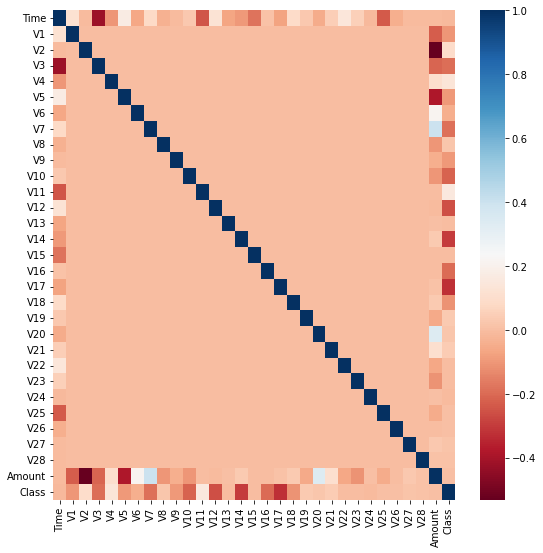

In [47]:
plt.figure(figsize = (9, 9))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu') # RdBu : 값이 클수록 (양의 상관관계일 수록) 색깔이 진한 파란색에 가깝게, 값이 작을 수록 (음의 상관관계일 수록) 빨간색에 가깝게 조정

=> 'Class'와 V17과 V14가 음의 상관관계가 가장 높음

In [51]:
# 예로 v17 컬럼의 이상치 추출
fraud = card_df['V17'][card_df['Class']==1]
fraud

541       -2.830056
623        0.599717
4920      -4.781831
6108     -12.598419
6329       6.739384
            ...    
279863    -4.570529
280143    -3.267116
280149    -5.035326
281144    -4.614717
281674     0.903562
Name: V17, Length: 492, dtype: float64

In [58]:
fr_25 = np.percentile(fraud.values, 25) #1사분위 지점
fr_75 = np.percentile(fraud.values, 75) #3사분위 지점
iqr = fr_75-fr_25
lower_val = fr_25 - iqr*1.5
high_val = fr_75 + iqr*1.5
print(lower_val, high_val)
# 이상치 
card_df[(card_df['Class']==1)&(card_df['V17']<lower_val)|(card_df['V17']>high_val)]

-27.84973307168096 14.562735952416062


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


=> V17에는 이상치가 없음

In [59]:
# V14 컬럼 확인 (df, 컬럼값 넣었을 때 이상치 나오는 함수 생성)
def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[column][df['Class']==1]
    quentile_25 = np.percentile(fraud.values, 25)
    quentile_75 = np.percentile(fraud.values, 75)
    
    #IQR 추출
    iqr = quentile_75 - quentile_25
    lowest_val = quentile_25 - iqr*weight
    highest_val = quentile_75 + iqr*weight
    
    # 최댓값 보다 크거나 최솟값 보다 작으면 이상치로 출력
    outer_index = fraud[(fraud<lowest_val)|(fraud>highest_val)].index # 인덱스 반환
    return outer_index

In [68]:
out_index = get_outlier(df=card_df, column='V14', weight=1.5) # 총 4개 존재
out_index

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

이상치 값
-19.2143254902614
-18.8220867423816
-18.4937733551053
-18.0499976898594

 ---boxplot 시각화---


<AxesSubplot:xlabel='V14'>

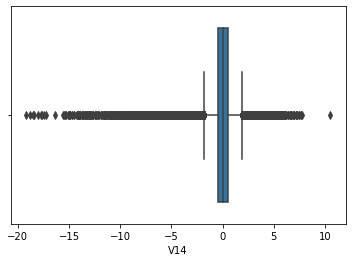

In [97]:
print('이상치 값')
for i in out_index.tolist():
    value = card_df.loc[i, 'V14']
    print(value)
    
print('\n','---boxplot 시각화---')
sns.boxplot(card_df.V14)

### 2) 이상치 제거 및 최종 활용 데이터 추출

In [98]:
# 이상치 제거 및 AMOUT 컬럼 log 변환하는 함수 생성
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace = True) # 필요없는 컬럼과 정규화하기전 컬럼 제거
    
    # 이상치 삭제 
    outlier_index = get_outlier(df=df_copy, column = 'V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

- 학습용, 테스트용 데이터를 생성 후 로지스틱과 LGBM모델로 학습/예측/평가

In [99]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('---------로지스틱 회귀 예측 성능---------')
lr_clf = LogisticRegression(max_iter=1000) #Gradient Descent 방식을 반복해서 몇번 수행할 것인지 지정
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) # 모델학습 인자로 집어넣어 평가 값 구하는 함수사용

print('---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

print('---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) 
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test) 

---------로지스틱 회귀 예측 성능---------
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------
오차 행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534,    F1: 0.7774, AUC:0.9219
---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


=> 원본데이터 대비 로지스틱 회귀, LGBM 모두 예측성능이 향상됨

## 3. SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

In [24]:
#SMOTE 클래스를 위해 설치
!pip install scikit-learn==0.23.1 --user
!pip install imbalanced-learn==0.7.0 --user

### 1) 오버 샘플링 적용

In [25]:
from imblearn.over_sampling import SMOTE

In [102]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train) # fit_resample매서드: 소수의 레이블 값을 다수의 레이블 개수 만큼 증식
print('오버 샘플링 적용 전 피처/ 레이블 데이터 세트:', X_train.shape, y_train.shape)
print('오버 샘플링 적용 후 피처/ 레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('오버 샘플링 적용 후 값 분포: \n', pd.Series(y_train_over).value_counts())

오버 샘플링 적용 전 피처/ 레이블 데이터 세트: (199362, 29) (199362,)
오버 샘플링 적용 후 피처/ 레이블 데이터 세트: (398040, 29) (398040,)
오버 샘플링 적용 후 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


-> 2배가까이 증식이 되었고 레이블 값에대한 분포가 균일해짐

### 2) 모델 학습/예측 적용

In [103]:
print('---------로지스틱 회귀 예측 성능---------')
lr_clf = LogisticRegression(max_iter=1000) #Gradient Descent 방식을 반복해서 몇번 수행할 것인지 지정
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test) # 훈련용만 오버 샘플링 데이터로 변경

print('---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1) 
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test) 

print('---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False) 
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test) 

---------로지스틱 회귀 예측 성능---------
오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737
---------LightGBM 예측 성능<boost_from_average 지정 안했을때>---------
오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814
---------LightGBM 예측 성능<boost_from_average=False로 지정 했을 때>---------
오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


- 로지스틱 회귀: 재현율 증가 but 정밀도 감소(0.05) => (레이블이 1인 데이터를 너무 많이 학습하여 지나치게 1로 예측하여 정밀도가 떨어지게됨)
- LGBM: 재현율 증가 but 정밀도 조금 감소

-> 정밀도보다 재현율을 높이는 경우 SMOTE 주사용

로지스틱 회귀에서 임계값이 변하는 정도


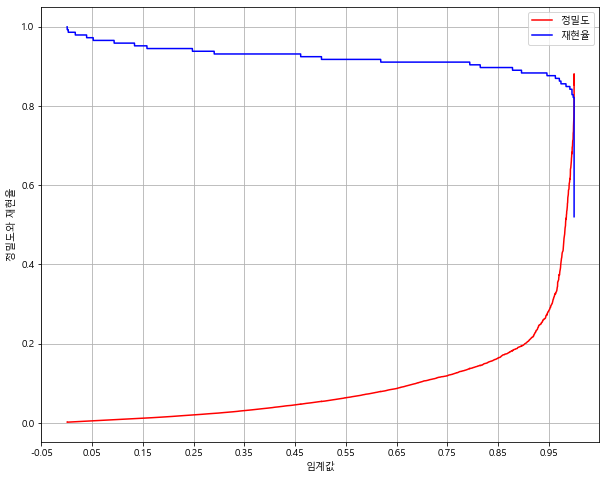

In [107]:
# 임계값에 따른 정확도, 정밀도 시각화
from sklearn.metrics import precision_recall_curve
from matplotlib import font_manager, rc
font_path = 'C:/cakd7/git/class/study/m3_통계/data/malgun.ttf' #malgun 폰트 저장 후 불러오기
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)
plt.rcParams['axes.unicode_minus'] = False  #마이너스 부호 출력 하게끔

def precision_recall_curve_plot(y_test, pred_proba):
    # 임곗값에 따른 정밀도, 재현율 추출
    precision, recall, thresholds = precision_recall_curve(y_test, pred_proba) 
    
    # X축 : 임계값, y축 정밀도, 재현율 값
    plt.figure(figsize = (10, 8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precision[0:threshold_boundary], linestyle = '-', label = '정밀도', color = 'red')
    plt.plot(thresholds, recall[0: threshold_boundary], label = '재현율', color = 'blue')
    
    # 임계값 (X)축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x, y축 라벨과 범례, 눈금 설정
    plt.xlabel('임계값')
    plt.ylabel('정밀도와 재현율')
    plt.legend()
    plt.grid()
    plt.show()
    
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
print('로지스틱 회귀에서 임계값이 변하는 정도')
precision_recall_curve_plot(y_test, pred_proba)

LGBMBoost에서 임계값이 변하는 정도


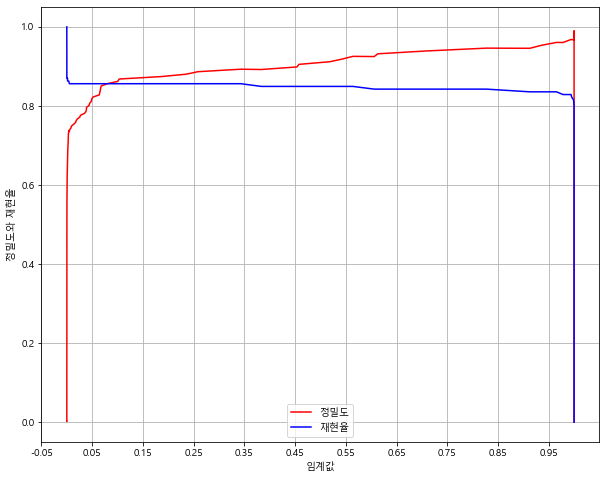

In [108]:
pred_proba =lgbm_clf.predict_proba(X_test)[:, 1]
print('LGBMBoost에서 임계값이 변하는 정도')
precision_recall_curve_plot(y_test, pred_proba)

- SMOTE를 적용하면 재현율은 증가하지만 정밀도는 감소하는게 일반적 (머신러닝 모델의 주목표)